In [2]:
import sys
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy.ndimage import zoom
from scipy import spatial
from copy import copy
import shapefile
from shapely.geometry import Point
from shapely.geometry import shape
import subprocess
from IPython.display import display, clear_output #needed for animated plots
from inpaint_nans import inpaint_nans

In [3]:
#create configuration file specifying some parameters for PISM
filename = "icecap_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

attrs = {"ocean.always_grounded": "yes",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": 3.0e-24,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "constants.standard_gravity": 9.8,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [4]:
#produce netCDF file specifying grid, bed, mass balance and ice temperature
WRIT_FILE = 'icecap_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 900.0             # [kg m-3]

Lx = 2 * 25e3  # in m
Ly = 2 * 25e3  # in m

dx, dy = 1e3,1e3

# grid size: # of boxes

ny = int(np.floor(Lx / dx) + 1)  # make it an odd number
nx = int(np.floor(Ly / dy) + 1)  # make it an odd number

# grid size: extent in m's, origin (0,0) in the center of the domain

x = np.linspace(-Lx, Lx, nx)
y = np.linspace(-Ly, Ly, ny)

nxcenter = int(np.floor(0.5 * nx))
nycenter = int(np.floor(0.5 * ny))

surf = np.ones((ny, nx))
B_ref = np.zeros((ny, nx))
ice_surface_temp = np.ones((ny, nx))*273
M_ref = np.zeros((ny, nx))


for i in range(0, nx):
    for j in range(0, ny):
        dist = ((x[i])**2+(y[j])**2)**0.5
        dist2a=((x[i]-Lx/5)**2+(y[j]-Ly/5)**2)**0.5
        dist2b=((x[i]+Lx/5)**2+(y[j]+Ly/5)**2)**0.5
        dist2c = ((2*(x[i])+Lx/5)**2+(2*(y[j])-Ly/5)**2)**0.5
        dist2d = ((2*(x[i])-Lx/5)**2+(2*(y[j])+Ly/5)**2)**0.5
        B_ref[i, j] = np.maximum(500*(1-dist2a*5/Lx),0)+np.maximum(500*(1-dist2b*5/Lx),0)+np.maximum(500*(1-dist2c*5/Lx),0)+np.maximum(500*(1-dist2d*5/Lx),0)
        #mass balance gradient (factor 1 is default)
        M_ref[i, j] = 5 *(1-(dist*2/Lx))
        surf[i,j] = B_ref[i,j]+1

thk = surf-B_ref

##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['m',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y],
        'x':    ['m',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x],
        'thk':  ['m',
                 'floating ice shelf thickness',
                 'land_ice_thickness',
                 1.0,
                 thk],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 0.0,
                 B_ref],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             273.0,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  0,
                                  M_ref * ice_density],  #note: unit is kg m-2 yr-1
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  icecap_initialSetup.nc  created



In [246]:
np.sum(dh_f)

39.340492

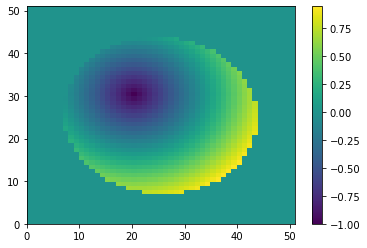

In [245]:
#plot some variable to check
dh_f = np.zeros_like(S_ref)
for i in range(0, nx):
    for j in range(5, ny-5):
        dist = ((x[i-5])**2+(y[j+5])**2)**0.5
        dh_f[i,j] = -1*(1-1.9*dist/Lx)*mask[i,j]
fig, axes = plt.subplots()
colors = plt.pcolor(dh_f, axes=axes)
fig.colorbar(colors)

In [55]:
def create_script(forward_or_iteration, nx, ny):
    print("""#!/bin/bash
    ###### run script for experiment synthetic1 ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx {} -My {} -Mz 30 -Mbz 1 -Lz 2000 -Lbz 1"'.format(nx, ny))
    print('PHYS="-stress_balance sia -sia_flow_law isothermal_glen -ssa_flow_law isothermal_glen"')
    print('THERMAL="-energy none"')
    print('OCEAN="-dry"')
    print('CONF="-config_override icecap_conf.nc"')

    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.33333 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant -tauc 2e7"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# initialize synthetic glacier"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag,enthalpybase,bwat"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times"')
    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $CONF $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [56]:
#create shell script with above function by directing output of function to file
original_stdout = sys.stdout # Save a reference to the original standard output
with open('icecap_build_script.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file
    create_script('forward', nx, ny)
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()

In [57]:
#make shell script executable
!chmod +x icecap_build_script.sh
# run shell script with 4 cores for 15000 yrs; save log in txt file
!./icecap_build_script.sh 6 icecap_initialSetup.nc 15000 icecap_output.nc 100 > icecap_output_log.txt

In [58]:
# check if log looks alright
!tail icecap_output_log.txt

v$$Eh  diffusivity (overrides end of the run) (dt=0.19443)
S    14999.548:    0.00230    0.01040          0.07828      0.00000
v$$Eh  diffusivity (overrides end of the run) (dt=0.19443)
S    14999.742:    0.00230    0.01040          0.07828      0.00000
v$$Eh  diffusivity (overrides end of the run) (dt=0.19443)
S    14999.937:    0.00230    0.01040          0.07828      0.00000
v$$Eh  end of the run (overrides reporting (-extra_times)) (dt=0.06314)
S    15000.000:    0.00230    0.01040          0.07828      0.00000
... done with run
Writing model state to file `icecap_output.nc'...


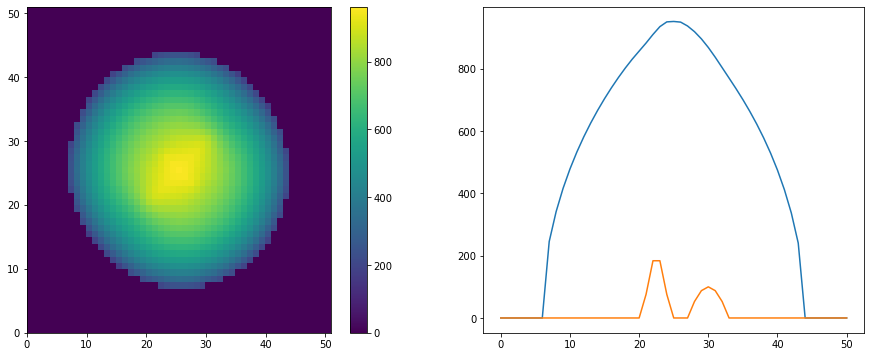

In [80]:
### check netCDF output ###
def get_nc_data(file, var, time):
    ds = NC(file)
    avail_vars = [nc_var for nc_var in ds.variables]
    if var not in avail_vars:
        raise ValueError('variable not found; must be in {}'.format(avail_vars))
    else:
        var_data = ds[var][time][:]
    return var_data
    
def plots(nrow=1, ncol=2, size=(10,4)):
    fig, axes = plt.subplots(nrow, ncol, figsize=size)
    #for ax in axes:
        #ax.set_box_aspect(1)
    return fig, axes

def scale(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

def gauss_filter(U, sigma, truncate):

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

mask = get_nc_data('ex_icecap_output.nc', 'mask', -1)/2

# load some output to check how it looks
nc_data = get_nc_data('ex_icecap_output.nc', 'usurf', -1)
nc_data2 = get_nc_data('icecap_output.nc', 'topg', 0)
fig, axes = plt.subplots(1,2,figsize=(15,6))
colors = axes[0].pcolor(nc_data)
fig.colorbar(colors, ax=axes[0])
axes[1].plot(range(nx), nc_data[26,:])
axes[1].plot(range(nx), nc_data2[26,:])

In [16]:
from scipy.interpolate import griddata
def shift(data, u, v, dx):
    x_shift, y_shift = np.meshgrid(range(nx), range(ny))
    uv_mag = np.ones_like(u)
    uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)

    x_shift = x_shift+(u/uv_mag)*dx
    y_shift = y_shift+(v/uv_mag)*dx

    points = np.zeros((np.shape(u)[0]*np.shape(u)[1],2))
    points[:,0] = x_shift.flatten()
    points[:,1]=y_shift.flatten()
    xi, yi = np.meshgrid(range(nx), range(ny))

    newgrid = griddata(points, data.flatten(), (xi.flatten(), yi.flatten())).reshape(np.shape(u))
    return newgrid

**SAVE THE NOTEBOOK!!**

In [110]:
pmax = 1000
dt = 0.1
beta = 1
bw = 4
#bws = [0,1,2,3,4,5]

#message = 'sensitivity to buffer width: '
#ids = []
#for bw in bws:    
#    id_string = ('buffer_it{}_bw{}_beta{}_dt{}_sia.pkl'.format(pmax, bw, beta, dt))
#    ids.append(id_string)
#    message += ' {};'.format(id_string)
     
    
#!git add synthetic_homegrown.ipynb
#cmd = ["git", "commit", "-m", message]
#subprocess.call(cmd)

In [247]:
    #for b,bw in enumerate(bws):
    
    ### bed recovery ###    
    S_ref = get_nc_data('icecap_output.nc', 'usurf', 0)
    S_rec = copy(S_ref)
    
    h_ref = get_nc_data('icecap_output.nc', 'thk', 0)
    B_rec = copy(S_ref) #start bed recovery from bed=0
    dh_ref = copy(dh_f)#mask*np.random.normal(0, 1, size=(np.shape(S_ref))) #assume that reference ice cap is in steady-state --> dhdt zero everywhere
    B_init = copy(B_rec)
    mask = get_nc_data('icecap_output.nc', 'mask', 0)/2
    
    B_rec_all = []
    dh_all = []
    misfit_all = []
    B_misfit_vs_iter=[]
    dh_misfit_vs_iter=[]
    S_rec_all = []
    
    !cp icecap_output.nc icecap_iteration_out.nc
        
    original_stdout = sys.stdout
    with open('icecap_iteration_script.sh', 'w') as f:
        sys.stdout = f
        create_script('iteration', nx, ny)
        sys.stdout = original_stdout
        f.close()
        
    !chmod +x icecap_iteration_script.sh

In [248]:
    for p in tqdm.trange(0, pmax):
        
        h_old = S_rec - B_rec
        
        !cp icecap_iteration_out.nc icecap_iteration_in.nc
        nc_updated = NC('icecap_iteration_in.nc', 'r+')
        nc_updated['topg'][0,:,:]=B_rec
        nc_updated['thk'][0,:,:]=h_old
        nc_updated.close()
    
        
        cmd = ["./icecap_iteration_script.sh", '5', 'icecap_iteration_in.nc', str(dt), 'icecap_iteration_out.nc', str(dt/2)]
        subprocess.call(cmd, stdout=open('icecap_iteration_log.txt', 'a'))
        
        #h_rec = get_nc_data('s_synthetic_iteration_out2.nc', 'thk', -1)
        h_rec = get_nc_data('icecap_iteration_out.nc', 'thk', 0)
        
        dh_rec = (h_rec - h_old)/dt
        misfit = (dh_rec - dh_ref)
        
        u = get_nc_data('icecap_iteration_out.nc', 'uvelsurf', 0)
        v = get_nc_data('icecap_iteration_out.nc', 'vvelsurf', 0)
        
        mask_iter = get_nc_data('icecap_iteration_out.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
        k = np.ones((bw, bw))
        buffer = ndimage.convolve(mask_iter, k)/(bw)**2 #smooth ice mask...
        criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)
        u[criterion]=0
        v[criterion]=0
        
        misfit = shift(misfit, u, v,.3)
        
        misfit[mask==0] = np.nan
        misfit = gauss_filter(misfit, 1, 4)
        misfit[np.isnan(misfit)] = 0
        misfit *= mask
        #mis_neg = misfit<0
        #mis_pos = misfit>0
        #misfit[mis_neg] = (misfit[mis_neg]/np.sum(abs(misfit[mis_neg])))*np.sum(abs(shift(dh_rec - dh_ref, u, v, .3)[shift(dh_rec-dh_ref, u , v, .3)<0]))
        #misfit[mis_pos] = (misfit[mis_pos]/np.sum(abs(misfit[mis_pos])))*np.sum(abs(shift(dh_rec-dh_ref, u , v, .3)[shift(dh_rec-dh_ref, u , v, .3)>0]))
        #misfit = spline_filter(misfit, lmbda=1)
        
        B_rec -= beta * misfit
        S_rec[mask==1] += (0.05*beta) * misfit[mask==1]
        
        #buffer2 = ndimage.convolve(mask, np.ones((bw, bw)))/bw**2
        #criterion2 = np.logical_and(buffer2 >0, buffer2 != 1)
        #S_rec[criterion2] = S_ref[criterion2]
        
        ### buffer ###
        h_inpaint = S_rec-B_rec
        h_inpaint[criterion] = np.nan #...and take those values in the transition between ice and no ice;
        h_inpaint = inpaint_nans(h_inpaint)
        B_rec = S_rec - h_inpaint
        ### buffer end ###
        
        B_rec[B_rec>S_rec]=S_rec[B_rec>S_rec]
        B_rec[mask == 0]= S_ref[mask == 0]
        S_rec[mask == 0]= S_ref[mask == 0]
        B_rec_all.append(B_rec)
        dh_all.append(dh_rec)
        misfit_all.append(misfit)
        S_rec_all.append(S_rec)
        
        B_misfit_vs_iter.append(np.mean(abs(B_rec-B_ref)))
        dh_misfit_vs_iter.append(np.mean(abs(dh_rec-dh_ref)))

    ## save output    
    #import shelve
    #bk = shelve.open('./{}'.format(ids[b]),'n')
    #for k in dir():
    #    try:
    #        bk[k] = globals()[k]
    #    except Exception:
    #        print('{} was not saved'.format(k))
    #        pass
    #bk.close()

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-16-cebfe2c0665c>:5: RuntimeWarning: invalid value encountered in sqrt
  uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
<ipython-input-80-b6fb83a5b54d>:30: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW
100%|██████████| 1000/1000 [15:29<00:00,  1.08it/s]


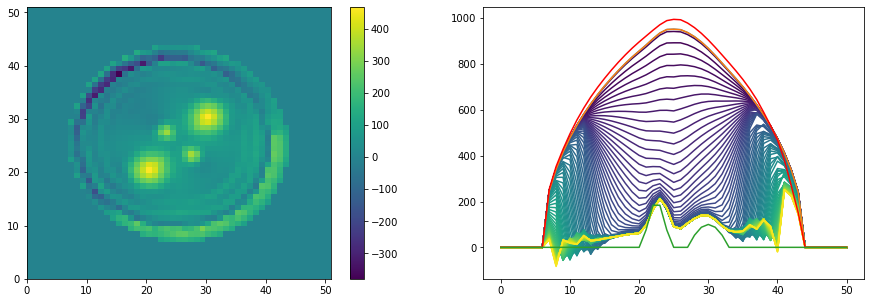

In [256]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
fig, axes = plt.subplots(1,2, figsize=(15,5))
field = axes[0].pcolor(B_rec_all[-1])#, vmin=-50, vmax=50, cmap='RdBu')
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),10):
    lines = axes[1].plot(range(nx), B_rec_all[i][26,:], color=colors[i])
lines2 = axes[1].plot(range(nx), S_ref[26,:])
lines2 = axes[1].plot(range(nx), B_init[26,:])
lines2 = axes[1].plot(range(nx), S_rec[26,:], color='r')
lines2 = axes[1].plot(range(nx), B_ref[26,:])

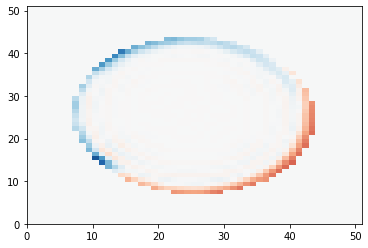

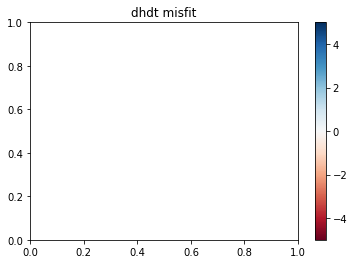

In [252]:
fig, axes = plt.subplots()
for i in range(0,len(B_rec_all),10):
    field = axes.pcolor(misfit_all[i], cmap='RdBu', vmin=-5, vmax=5)
    #field = axes.pcolor(S_rec_all[i]-B_rec_all[i], vmax=1000, vmin=0)
    clear_output(wait=True)
    display(fig)
    axes.cla()
axes.set_title('dhdt misfit')
fig.colorbar(field)

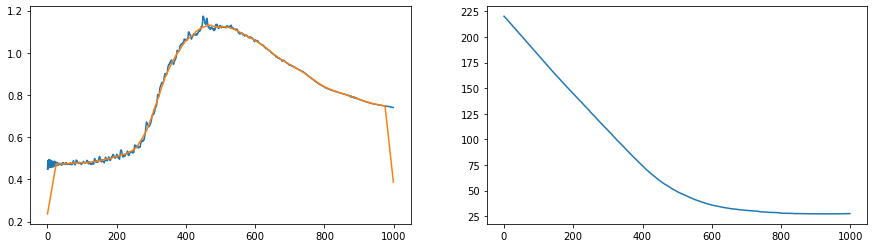

In [253]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
line = ax[0].plot(dh_misfit_vs_iter)
#ax[0].set_ylim([0,2])
line1 = ax[0].plot(np.convolve(dh_misfit_vs_iter, np.ones(50)/50, mode='same'))
line2 = ax[1].plot(B_misfit_vs_iter)

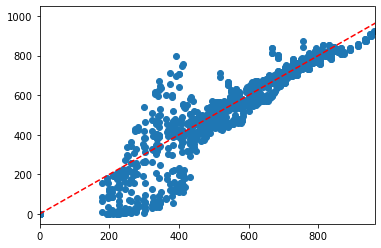

In [254]:
cors = []
thk_rec_all = []
for i in range(0,len(B_rec_all),1):
    thk_rec = S_rec_all[i] - B_rec_all[i]#ndimage.convolve(S_ref-B_rec_all[-1], np.ones((4,4))/16)
    thk_rec_all.append(thk_rec)
    cors.append(np.corrcoef(h_ref, thk_rec)[0][1])

fig, ax = plt.subplots()
field = ax.scatter(h_ref, thk_rec_all[-1])
#ax.set_aspect(1)
ax.set_xlim([0,np.max(h_ref)])
#ax.set_ylim([0,np.max(h_ref)])
ax.plot(range(1000), range(1000), 'r', linestyle='--')

In [255]:
import scipy.stats as st
#max_cor_ind = int(np.where(cors==np.max(cors))[0])
dev = (thk_rec_all[-1]-h_ref)/np.mean(h_ref)
mean_dev = np.nanmean((dev))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
print('mean deviation: {}'.format(mean_dev))
print('median deviation: {}'.format(med_dev))
print('Interquartile range of deviation: {}'.format(IQR_dev))
print('95% confidence intervall: {}'.format(conf_dev))

mean deviation: -0.052558559171170846
median deviation: 0.0
Interquartile range of deviation: 0.0059407065446685225
95% confidence intervall: [ 0.01172928 -0.01172928]
